In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import scipy.stats as stats
from scipy.stats import zscore

## Load data

In [2]:
df = pd.read_csv('data_for_distribution.csv')
df

,Unique_ID,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,Class
0,A04812,SOLVE003,561,571.0,NaN,0.066,1031.00,61380.0,138.2000,3.600,3586.0000,43.6000,A
1,A03356,SOLVE003,571,581.0,NaN,0.152,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,A
2,A04764,SOLVE003,581,591.0,NaN,0.068,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,A
3,A04626,SOLVE003,591,601.0,NaN,0.074,891.60,48620.0,63.0000,4.200,820.8000,39.6000,A
4,A05579,SOLVE003,601,611.0,NaN,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4766,A06258,SOLVE291,1281,1291.0,9.0,0.03,74.80,53460.0,2.4000,3.000,3300.0000,27.6000,?
4767,A04915,SOLVE291,1291,1301.0,12.2,0.064,208.20,51500.0,2.6000,3.000,4200.0000,29.4000,?
4768,A06596,SOLVE291,1301,1311.0,10.4,0.024,145.40,55040.0,2.6000,3.000,6160.0000,34.6000,?
4769,A07560,SOLVE291,1311,1321.0,10.0,0.011,109.60,55460.0,2.6000,4.000,5700.0000,33.4000,?


In [4]:
## rename columns for personal preference
df.rename(columns={'Class': 'label'}, inplace=True)
df.rename(columns={'Unique_ID': 'id'}, inplace=True)
df = df.replace('A', 'proximal')
df = df.replace('B', 'distal')
df.head()

,id,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,label
0,A04812,SOLVE003,561,571.0,NaN,0.066,1031.00,61380.0,138.2000,3.600,3586.0000,43.6000,proximal
1,A03356,SOLVE003,571,581.0,NaN,0.152,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,proximal
2,A04764,SOLVE003,581,591.0,NaN,0.068,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,proximal
3,A04626,SOLVE003,591,601.0,NaN,0.074,891.60,48620.0,63.0000,4.200,820.8000,39.6000,proximal
4,A05579,SOLVE003,601,611.0,NaN,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,proximal


## EDA

In [6]:
# ## understand the label split by counting labels per group and finding the percentages of the total group, noticed the class imbalance
counts = df['label'].value_counts()
percentages = df['label'].value_counts(normalize=True) * 100  # Convert to percentage
summary_df = pd.DataFrame({'Count': counts, 'Percentage': percentages})
summary_df.reset_index(inplace=True)
summary_df.rename(columns={'index': 'Category'}, inplace=True)
summary_df

,label,Count,Percentage
0,proximal,2861,59.966464
1,distal,1143,23.957242
2,?,767,16.076294


In [7]:
#check the dtypes for anything odd --> odd that Au is an object so investigate further
df.dtypes

id         object
holeid     object
from        int64
to        float64
As        float64
Au         object
Pb        float64
Fe        float64
Mo        float64
Cu        float64
S         float64
Zn        float64
label      object
dtype: object

In [8]:
## needed to fix the Au <DL to have it described so moved this step ahead from qaqc
## fixing gold <DL by replacing with 1/2 LDL
df['Au'] = df['Au'].apply(lambda x: float(x[1:])/2 if isinstance(x, str) and x.startswith('<') else float(x))
df.head()

,id,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,label
0,A04812,SOLVE003,561,571.0,NaN,0.066000,1031.00,61380.0,138.2000,3.600,3586.0000,43.6000,proximal
1,A03356,SOLVE003,571,581.0,NaN,0.152000,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,proximal
2,A04764,SOLVE003,581,591.0,NaN,0.068000,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,proximal
3,A04626,SOLVE003,591,601.0,NaN,0.074000,891.60,48620.0,63.0000,4.200,820.8000,39.6000,proximal
4,A05579,SOLVE003,601,611.0,NaN,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,proximal


In [9]:
## Run summary stats to get a quick overview of the data
summary = df.describe()
summary

,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn
count,4771.000000,4771.000000,3268.000000,4765.000000,4756.000000,4709.000000,4741.000000,4746.000000,4761.000000,4762.000000
mean,750.379585,760.353574,19.730855,0.051956,689.831232,49952.514598,9.991452,12.450601,9750.033213,59.389636
std,447.126995,447.114592,37.181529,0.089862,1047.642566,21490.606419,87.098943,107.438873,15557.657335,120.489477
min,71.000000,81.000000,1.000000,0.002500,1.600000,2080.000000,-999.000000,1.000000,26.000000,5.600000
25%,421.000000,431.000000,5.400000,0.010000,132.200000,39260.000000,1.400000,3.000000,1338.000000,29.800000
50%,641.000000,651.000000,9.200000,0.027000,396.700000,49020.000000,4.400000,4.600000,3636.000000,38.200000
75%,991.000000,1001.000000,20.000000,0.061000,940.200000,58420.000000,17.400000,8.000000,10988.000000,52.600000
max,2201.000000,2211.000000,827.800000,1.878000,29793.800000,397000.000000,1939.400000,6767.000000,217600.000000,3455.000000


## QAQC

Drillhole Sample & Interval Investigation

In [10]:
#count number of samples in each hole ID
value_counts = df['holeid'].value_counts()
value_counts= value_counts.reset_index()
value_counts.columns = ['holeid', 'Count']
#Visualize top 25
top_25 = value_counts.head(25)
top_25

,holeid,Count
0,SOLVE236,164
1,SOLVE279A,163
2,SOLVE237,154
3,SOLVE197,141
4,SOLVE196,136
5,SOLVE198,129
6,SOLVE127,126
7,SOLVE064,119
8,SOLVE195W3,105
9,SOLVE080,103


In [11]:
# Visualize bottom 25
lowest_25 = value_counts.tail(25)
lowest_25
## most likely missing data for the holes containing only 1-10~ samples. I would flag this before moving forward and look into it if time permiited

,holeid,Count
115,SOLVE234,6
116,SOLVE104,6
117,SOLVE108,6
118,SOLVE181W1,6
119,SOLVE099,6
120,SOLVE195W2,6
121,SOLVE201,5
122,SOLVE003,5
123,SOLVE015,5
124,SOLVE010,4


In [12]:
# calculate the interval lengths & then visualize the unique interval lengths and count for each to check for any very short or long intervals that would require flagging
df['interval_length'] = df['to'] - df['from']
interval_length = df['interval_length'].value_counts()
interval_length
## lengths seem reasonable

interval_length
10.00    4723
6.00        3
9.50        3
7.50        2
9.40        2
5.30        2
6.60        2
5.40        2
9.90        2
8.60        2
5.70        2
9.30        2
6.70        1
8.32        1
6.30        1
6.50        1
9.20        1
6.40        1
8.40        1
5.10        1
9.70        1
5.43        1
8.20        1
7.40        1
6.75        1
5.80        1
7.40        1
5.20        1
8.60        1
8.70        1
7.70        1
7.20        1
5.60        1
8.00        1
7.60        1
7.80        1
Name: count, dtype: int64

In [13]:
#save this for later use 
df=df.set_index("id")
df_meta=df[['holeid', 'from', 'to', 'label']]
df_label=df[['label']]
df_label=df_label.reset_index()

In [14]:
# check what label(s) exist for each holdeid (proximal, distal or both)
unique_counts = df.groupby("holeid")["label"].nunique()
unique_labels = df.groupby("holeid")["label"].unique()
result = pd.DataFrame({"Unique_Count": unique_counts, "Unique_Labels": unique_labels})
result.head(50)
## odd that many of the holes are just proximal

,Unique_Count,Unique_Labels
holeid,,
SOLVE003,1,[proximal]
SOLVE004,1,[proximal]
SOLVE007,1,[proximal]
SOLVE008,2,"[distal, proximal]"
SOLVE010,1,[proximal]
SOLVE011,1,[proximal]
SOLVE015,1,[proximal]
SOLVE016,1,[proximal]
SOLVE017,1,[proximal]


In [15]:
## look at specific drill holes and visualize downhole plot with labels to check for missing intervals
## using SOLVE080 as an example -- would ideally look at all drill holes if time permitted
SOLVE080_df = df_meta[df_meta['holeid'] == 'SOLVE080']
SOLVE080_df.shape

(103, 4)

/var/folders/zs/pty16hcd2clbfx__htmdtdxr0000gn/T/ipykernel_2628/159185391.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


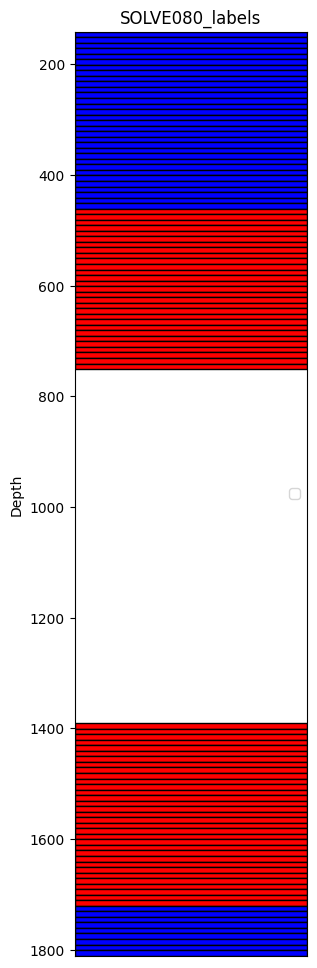

In [17]:
##Create a downhole plot to viz drillhole intervals & labels
# Define colors for proximal & distal
colors = {
    "proximal": "red",
    "distal": "blue"
}

fig, ax = plt.subplots(figsize=(3, 12))

for _, row in SOLVE080_df.iterrows():
    ax.barh(
        y=(row['from'] + row['to']) / 2,  
        width=1,  # Bar width
        height=row['to'] - row['from'],  
        color=colors.get(row['label'], "black"),
        edgecolor='black',
        align='center'
    )
    
ax.set_ylim(max(SOLVE080_df["to"]), min(SOLVE080_df["from"]))  # Reverse depth axis
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_ylabel("Depth")
ax.set_title("SOLVE080_labels")
plt.legend()
plt.show()
## note the missing data in the middle of the hole

NaNs

In [18]:
## Add a total NaN count at the bottom of each column
df.loc['NaN_count'] = df.isna().sum()
df

,holeid,from,to,As,Au,Pb,Fe,Mo,Cu,S,Zn,label,interval_length
id,,,,,,,,,,,,,
A04812,SOLVE003,561,571.0,NaN,0.066000,1031.00,61380.0,138.2000,3.600,3586.0000,43.6000,proximal,10.0
A03356,SOLVE003,571,581.0,NaN,0.152000,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,proximal,10.0
A04764,SOLVE003,581,591.0,NaN,0.068000,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,proximal,10.0
A04626,SOLVE003,591,601.0,NaN,0.074000,891.60,48620.0,63.0000,4.200,820.8000,39.6000,proximal,10.0
A05579,SOLVE003,601,611.0,NaN,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,proximal,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
A04915,SOLVE291,1291,1301.0,12.2,0.064000,208.20,51500.0,2.6000,3.000,4200.0000,29.4000,?,10.0
A06596,SOLVE291,1301,1311.0,10.4,0.024000,145.40,55040.0,2.6000,3.000,6160.0000,34.6000,?,10.0
A07560,SOLVE291,1311,1321.0,10.0,0.011000,109.60,55460.0,2.6000,4.000,5700.0000,33.4000,?,10.0


In [19]:
## notice that Arsenic contains 1503 NaNs so decided to drop this element from the analysis 
df= df.drop(columns=['As']) 
df = df.iloc[:-1]# dropping NaN_count row
df.head()

,holeid,from,to,Au,Pb,Fe,Mo,Cu,S,Zn,label,interval_length
id,,,,,,,,,,,,
A04812,SOLVE003,561,571.0,0.066000,1031.00,61380.0,138.2000,3.600,3586.0000,43.6000,proximal,10.0
A03356,SOLVE003,571,581.0,0.152000,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,proximal,10.0
A04764,SOLVE003,581,591.0,0.068000,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,proximal,10.0
A04626,SOLVE003,591,601.0,0.074000,891.60,48620.0,63.0000,4.200,820.8000,39.6000,proximal,10.0
A05579,SOLVE003,601,611.0,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,proximal,10.0


In [20]:
## other elements only have a few missing values so decided to drop the rest of the rows containing NaNs to ensure I have a complete data set for analysis 
df = df.dropna()
df.shape

(4643, 12)

Check for Duplicates in SampleID

In [21]:
df=df.reset_index()
num_duplicates = df['id'].duplicated().sum()
num_duplicates
## no duplicates found

np.int64(0)

Check for Duplicate intervals within each holeid

In [22]:
# # Check for duplicates in "from" for each unique holeid by creating a new df with each holeid as a column
dup_df = df.groupby('holeid')['from'].apply(list).apply(pd.Series).T
dup_df.head()

holeid,SOLVE003,SOLVE004,SOLVE007,SOLVE008,SOLVE010,SOLVE011,SOLVE015,SOLVE016,SOLVE017,SOLVE021,...,SOLVE231,SOLVE232,SOLVE233,SOLVE234,SOLVE236,SOLVE237,SOLVE278,SOLVE279A,SOLVE280,SOLVE291
0,561.0,541.0,561.0,211.0,521.0,791.0,861.0,671.0,1141.0,811.0,...,71.0,141.0,111.0,121.0,121.0,101.0,931.0,221.0,1251.0,371.0
1,571.0,551.0,571.0,221.0,531.0,801.0,871.0,681.0,1151.0,821.0,...,81.0,151.0,121.0,131.0,131.0,111.0,941.0,231.0,1261.0,381.0
2,581.0,561.0,581.0,231.0,541.0,811.0,881.0,691.0,1161.0,831.0,...,91.0,161.0,131.0,141.0,141.0,121.0,951.0,241.0,1271.0,401.0
3,591.0,571.0,591.0,241.0,551.0,821.0,891.0,701.0,1171.0,841.0,...,101.0,171.0,141.0,151.0,161.0,131.0,961.0,251.0,1281.0,411.0
4,601.0,581.0,611.0,251.0,NaN,831.0,901.0,711.0,1181.0,851.0,...,111.0,181.0,151.0,161.0,171.0,141.0,971.0,261.0,1291.0,421.0


In [23]:
#applying a function to check for duplicate from values for each holeid
duplicates = dup_df.apply(lambda col: col.duplicated(keep=False) & col.notna())
# Filter and print only duplicate values
for col in dup_df.columns:
    dup_values = dup_df.loc[duplicates[col], col]
    if not dup_values.empty:
        print(f"Duplicates in column '{col}':")
        print(dup_values.to_list())
## none found

Create probability plots to assess upper outliers / detection limit issues (using Pb as the example)

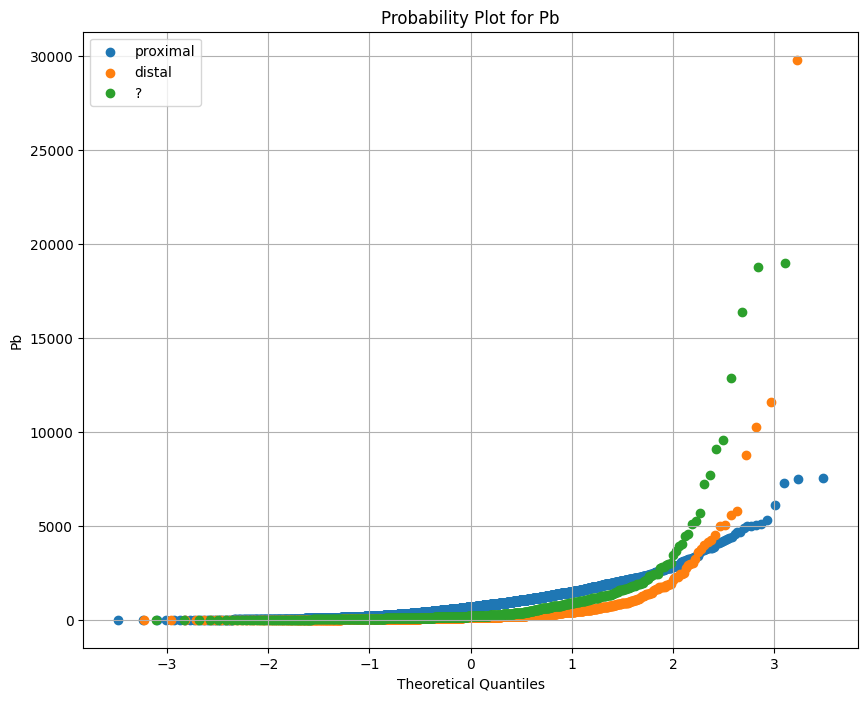

In [24]:
# 1. Create a probability plot --> normal data
plt.figure(figsize=(10, 8))
# Get unique labels
unique_labels = df['label'].unique()
# Plot for each label
for label in unique_labels:
    subset = df[df['label'] == label]['Pb']
    (osm, osr), (slope, intercept, r) = stats.probplot(subset, dist="norm", plot=None)
    plt.scatter(osm, osr, label=f'{label}')               
                
# Add labels and legend
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Pb')
plt.title('Probability Plot for Pb')
plt.legend()
plt.grid(True)
plt.show()

Define an upper percentile to drop for outliers --> experiment with values to see how the outlier plots look

In [25]:
upper_percentile = df['Pb'].quantile(0.99)
# Drop outliers
pb_cleaned = df[(df['Pb'] <= upper_percentile)]

pb_cleaned.shape

(4596, 13)

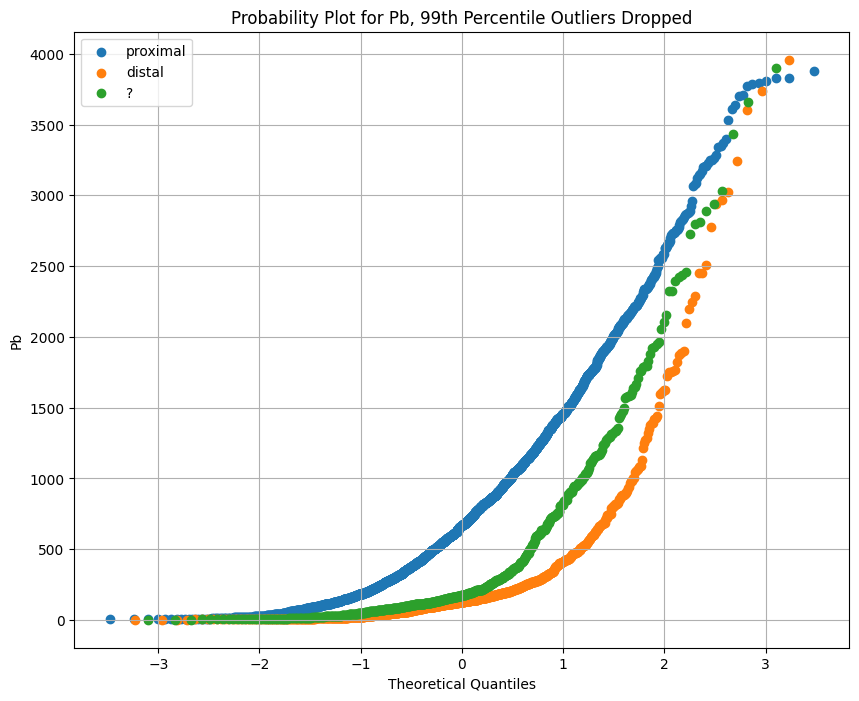

In [26]:
# 2. Create a probability plot with .99 percentile Pb dropped
plt.figure(figsize=(10, 8))

# Get unique labels
unique_labels = pb_cleaned['label'].unique()

# Plot for each label
for label in unique_labels:
    subset = pb_cleaned[pb_cleaned['label'] == label]['Pb']
    (osm, osr), (slope, intercept, r) = stats.probplot(subset, dist="norm", plot=None)
    plt.scatter(osm, osr, label=f'{label}')

# Add labels and legend
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Pb')
plt.title('Probability Plot for Pb, 99th Percentile Outliers Dropped')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
#try dropping .98 percentile values
upper_percentile = df['Pb'].quantile(0.98)
# Drop outliers
pb_cleaned = df[(df['Pb'] <= upper_percentile)]

pb_cleaned.shape

(4550, 13)

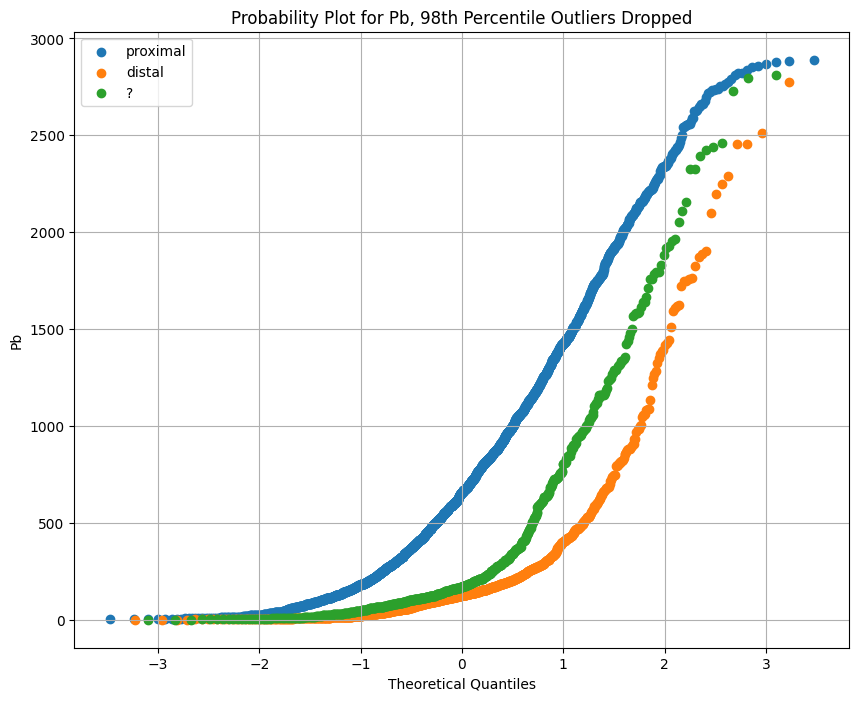

In [28]:
# 3. Create a probability plot with .98 percentile Pb dropped
plt.figure(figsize=(10, 8))

# Get unique labels
unique_labels = pb_cleaned['label'].unique()

# Plot for each label
for label in unique_labels:
    subset = pb_cleaned[pb_cleaned['label'] == label]['Pb']
    (osm, osr), (slope, intercept, r) = stats.probplot(subset, dist="norm", plot=None)
    plt.scatter(osm, osr, label=f'{label}')

# Add labels and legend
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Pb')
plt.title('Probability Plot for Pb, 98th Percentile Outliers Dropped')
plt.legend()
plt.grid(True)
plt.show()

Assign chosen upper DL limit to all elements ** with more time would have chosen each limit carefully by looking at probability plots, analytical method upper limits and assigning upper limit value.
Decided on 0.99 since that looked best for the example (Pb) -- this is likely not the best choice for all the elements but in the interest of time i have decided to assign this to all the elements.

In [29]:
# drop .99 percentile for Au
upper_percentile = df['Au'].quantile(0.99)
df_clean = df[(df['Au'] <= upper_percentile)]
df_clean.shape

(4596, 13)

In [30]:
# drop .99 percentile for Pb
upper_percentile = df_clean['Pb'].quantile(0.99)
df_clean= df_clean[(df_clean['Pb'] <= upper_percentile)]
df_clean.shape

(4550, 13)

In [31]:
# drop .99 percentile for Fe
upper_percentile = df_clean['Fe'].quantile(0.99)
df_clean = df_clean[(df_clean['Fe'] <= upper_percentile)]
df_clean.shape

(4504, 13)

In [32]:
# drop .99 percentile for Mo
upper_percentile = df_clean['Mo'].quantile(0.99)
df_clean = df_clean[(df_clean['Mo'] <= upper_percentile)]
df_clean.shape

(4458, 13)

In [33]:
# drop .99 percentile for Cu
upper_percentile = df_clean['Cu'].quantile(0.99)
df_clean = df_clean[(df_clean['Cu'] <= upper_percentile)]
df_clean.shape

(4413, 13)

In [34]:
# drop .99 percentile for S
upper_percentile = df_clean['S'].quantile(0.99)
df_clean = df_clean[(df_clean['S'] <= upper_percentile)]
df_clean.shape

(4368, 13)

In [35]:
# drop .99 percentile for Zn
upper_percentile = df_clean['Zn'].quantile(0.99)
df_clean = df_clean[(df_clean['Zn'] <= upper_percentile)]
df_clean.shape

(4324, 13)

In [38]:
## lost 319 values using .99 percentile. Again, this is not a 1 size fits all solution, but in the interest of time I will keep all the percentile drops the same.
df_clean

,id,holeid,from,to,Au,Pb,Fe,Mo,Cu,S,Zn,label,interval_length
1,A03356,SOLVE003,571,581.0,0.152000,1982.00,50860.0,75.4000,4.800,1822.0000,36.4000,proximal,10.0
2,A04764,SOLVE003,581,591.0,0.068000,1064.80,57940.0,29.2000,3.000,740.4000,36.6000,proximal,10.0
3,A04626,SOLVE003,591,601.0,0.074000,891.60,48620.0,63.0000,4.200,820.8000,39.6000,proximal,10.0
4,A05579,SOLVE003,601,611.0,0.043125,801.25,51025.0,56.0625,4.875,745.6875,32.3125,proximal,10.0
6,A04127,SOLVE004,551,561.0,0.098000,2679.00,59280.0,93.0000,3.000,2085.6000,23.4000,proximal,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4638,A06258,SOLVE291,1281,1291.0,0.030000,74.80,53460.0,2.4000,3.000,3300.0000,27.6000,?,10.0
4639,A04915,SOLVE291,1291,1301.0,0.064000,208.20,51500.0,2.6000,3.000,4200.0000,29.4000,?,10.0
4640,A06596,SOLVE291,1301,1311.0,0.024000,145.40,55040.0,2.6000,3.000,6160.0000,34.6000,?,10.0
4641,A07560,SOLVE291,1311,1321.0,0.011000,109.60,55460.0,2.6000,4.000,5700.0000,33.4000,?,10.0


In [39]:
## save as csv for use in the classification_task notebook
df_clean.to_csv('clean_data.csv')